In [273]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Adding a constant variable 
import statsmodels.api as sm  
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np

# Supress Warnings

import warnings
warnings.filterwarnings('ignore')


In [274]:
#import day.csv file
df = pd.read_csv('day.csv')

In [275]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Steps:
1) Divide Dataset into test, train
2) Convert String Categorical variables to numeric
3) View co-relation matrix
4) Build Model


In [276]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [277]:
pd.isnull(df).sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

### No null values hence no imputation required

### Visualise the Data-EDA

In [278]:
def univariate(df,col):
        sns.set(style="darkgrid")
        fig, ax=plt.subplots(nrows =1,ncols=2,figsize=(10,3))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[1])
        plt.show()

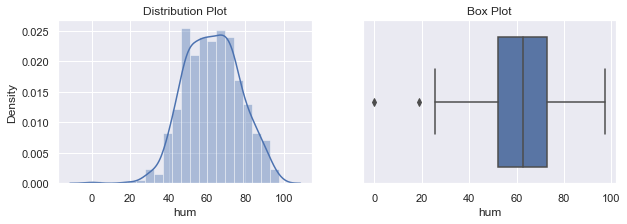

In [279]:
univariate(df=df,col='hum')

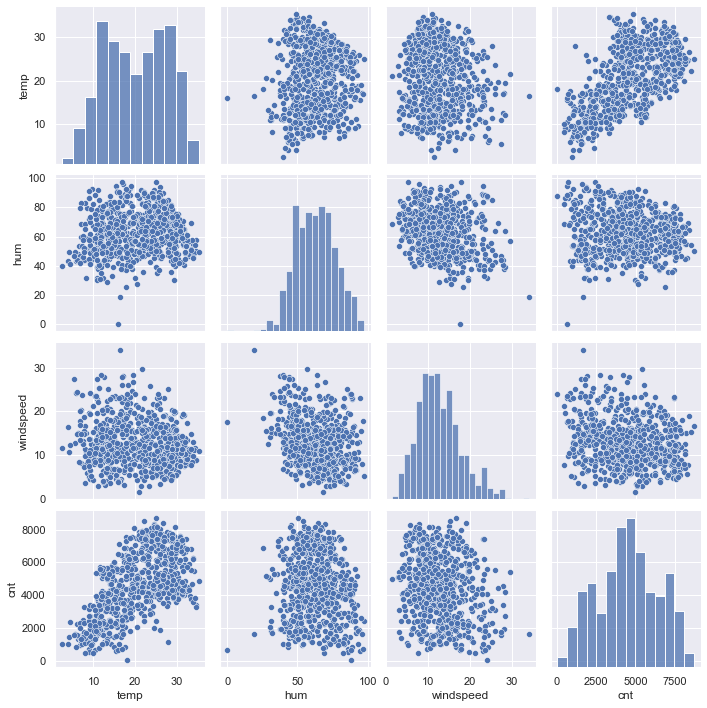

In [280]:
sns.pairplot(df[['temp','hum','windspeed','cnt']])
plt.show()

### Clearly from above plot temp and Cnt seems to have a linear relation

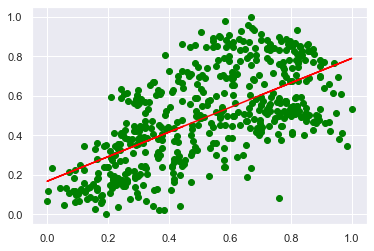

In [281]:
plt.plot(Xtrain.temp, ytrain, 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(Xtrain.temp, ytrain, 1)

#use red as color for regression line
plt.plot(Xtrain.temp, m*Xtrain.temp+b, color='red')

### Covert some numeric variables like 'weathersit' and 'season', mnth, weekday to categorical string values

In [282]:
#  maped weathersit column
df['weathersit']= df['weathersit'].map({1:'Clear',2:'Cloudy',3:'Snow',4:'Rain'})

#  maped season column
df['season']= df['season'].map({1:'spring',2:'summer',3:'fall',4:'winter'})

# maped mnth column values (1 to 12 ) as (jan to dec) respectively
df['mnth'] = df['mnth'].map({1:'jan', 2:'feb', 3:'mar', 4:'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep', 10: 'oct',
                             11: 'nov', 12:'dec'})

# maped the weekday column according to descriptin
df['weekday'] = df['weekday'].map({0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'})

### The variable 'weathersit' and 'season' has four levels. We need to convert these levels into integer as well. For this, we will use something called dummy variables.

In [283]:
# Get the dummy variables for the feature weathersit' and store it in a new variable - 'status'
df=pd.get_dummies(data=df, columns=['season', 'mnth','yr','weekday','weathersit'], drop_first = True)
df.head()

,instant,dteday,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,mnth_sep,yr_1,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Snow
0,1,01-01-2018,0,0,14.110847,18.18125,80.5833,10.749882,331,654,...,0,0,0,1,0,0,0,0,1,0
1,2,02-01-2018,0,0,14.902598,17.68695,69.6087,16.652113,131,670,...,0,0,0,0,1,0,0,0,1,0
2,3,03-01-2018,0,1,8.050924,9.47025,43.7273,16.636703,120,1229,...,0,0,1,0,0,0,0,0,0,0
3,4,04-01-2018,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,...,0,0,0,0,0,0,1,0,0,0
4,5,05-01-2018,0,1,9.305237,11.46350,43.6957,12.522300,82,1518,...,0,0,0,0,0,0,0,1,0,0


In [284]:

df.head()

,instant,dteday,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,mnth_sep,yr_1,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Snow
0,1,01-01-2018,0,0,14.110847,18.18125,80.5833,10.749882,331,654,...,0,0,0,1,0,0,0,0,1,0
1,2,02-01-2018,0,0,14.902598,17.68695,69.6087,16.652113,131,670,...,0,0,0,0,1,0,0,0,1,0
2,3,03-01-2018,0,1,8.050924,9.47025,43.7273,16.636703,120,1229,...,0,0,1,0,0,0,0,0,0,0
3,4,04-01-2018,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,...,0,0,0,0,0,0,1,0,0,0
4,5,05-01-2018,0,1,9.305237,11.46350,43.6957,12.522300,82,1518,...,0,0,0,0,0,0,0,1,0,0


In [285]:
print(df.shape)


(730, 34)


In [286]:
y = df['cnt']
X= df

## Splitting the dataset

In [287]:
# Splitting the data into Train and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.3, random_state=11)

## Apply scaling to numeric variables

In [288]:
num_cols = ['temp','atemp','hum','windspeed','cnt']

In [289]:
std = MinMaxScaler()
Xtrain[num_cols] = std.fit_transform(Xtrain[num_cols])
Xtrain

,instant,dteday,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,mnth_sep,yr_1,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Snow
115,116,26-04-2018,0,1,0.699403,0.701405,0.749786,0.745868,678,3722,...,0,0,0,0,0,0,1,0,0,0
562,563,17-07-2019,0,1,0.943365,0.930276,0.520137,0.183152,921,5865,...,0,1,0,0,0,0,1,0,0,0
523,524,08-06-2019,0,1,0.722275,0.706757,0.481149,0.344890,1488,6248,...,0,1,0,0,0,0,0,0,0,0
524,525,09-06-2019,0,0,0.802869,0.778287,0.449443,0.262379,2708,4790,...,0,1,0,1,0,0,0,0,0,0
268,269,26-09-2018,0,1,0.722275,0.694266,0.872322,0.173258,684,3946,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,270,27-09-2018,0,1,0.705938,0.673706,0.910454,0.193082,477,3643,...,1,0,0,0,0,0,1,0,1,0
337,338,04-12-2018,0,0,0.306231,0.354440,0.797772,0.102301,634,2851,...,0,0,0,0,1,0,0,0,0,0
91,92,02-04-2018,0,0,0.285538,0.307047,0.672237,0.402636,898,1354,...,0,0,0,1,0,0,0,0,1,0
80,81,22-03-2018,0,1,0.451085,0.484089,0.642245,0.478535,460,2243,...,0,0,0,0,0,0,1,0,0,0


In [290]:
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)
print(ytrain.head())
ytrain = Xtrain.pop('cnt')
print(ytrain.head())

(511, 34)
(219, 34)
(511,)
(219,)
115    4400
562    6786
523    7736
524    7498
268    4630
Name: cnt, dtype: int64
115    0.478545
562    0.766953
523    0.881784
524    0.853016
268    0.506346
Name: cnt, dtype: float64


In [291]:
#drop dteDay Since dteDay is covered under yr
df = df.drop('dteday',axis = 1)
Xtrain = Xtrain.drop('dteday',axis = 1)

#Drop instant since this is auto-increment number, will not have any significance in model
df = df.drop('instant',axis = 1)
Xtrain = Xtrain.drop('instant',axis = 1)

#Drop instant since this already connected to cnt, will be directly corelated to Cnt
df = df.drop('registered',axis = 1)
Xtrain = Xtrain.drop('registered',axis = 1)

#Drop instant since this already connected to cnt,  will be directly corelated to Cnt
df = df.drop('casual',axis = 1)
Xtrain = Xtrain.drop('casual',axis = 1)

In [292]:
df

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_sep,yr_1,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Snow
0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0,1,10.420847,11.33210,65.2917,23.458911,2114,1,0,0,...,0,1,0,0,0,1,0,0,1,0
726,0,1,10.386653,12.75230,59.0000,10.416557,3095,1,0,0,...,0,1,0,0,0,0,0,0,1,0
727,0,0,10.386653,12.12000,75.2917,8.333661,1341,1,0,0,...,0,1,0,1,0,0,0,0,1,0
728,0,0,10.489153,11.58500,48.3333,23.500518,1796,1,0,0,...,0,1,0,0,1,0,0,0,0,0


In [293]:
df.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_sep,yr_1,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Snow
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,...,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.028767,0.683562,20.319259,23.726322,62.765175,12.763620,4508.006849,0.246575,0.252055,0.243836,...,0.082192,0.500000,0.143836,0.143836,0.143836,0.142466,0.142466,0.141096,0.336986,0.028767
std,0.167266,0.465405,7.506729,8.150308,14.237589,5.195841,1936.011647,0.431313,0.434490,0.429689,...,0.274845,0.500343,0.351164,0.351164,0.351164,0.349767,0.349767,0.348359,0.473004,0.167266
min,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,22.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,3169.750000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000,0.000000,0.000000,0.000000,...,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,5966.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,8714.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [294]:
print(df.dtypes)

holiday                int64
workingday             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
cnt                    int64
season_spring          uint8
season_summer          uint8
season_winter          uint8
mnth_aug               uint8
mnth_dec               uint8
mnth_feb               uint8
mnth_jan               uint8
mnth_jul               uint8
mnth_jun               uint8
mnth_mar               uint8
mnth_may               uint8
mnth_nov               uint8
mnth_oct               uint8
mnth_sep               uint8
yr_1                   uint8
weekday_Mon            uint8
weekday_Sat            uint8
weekday_Sun            uint8
weekday_Thu            uint8
weekday_Tue            uint8
weekday_Wed            uint8
weathersit_Cloudy      uint8
weathersit_Snow        uint8
dtype: object


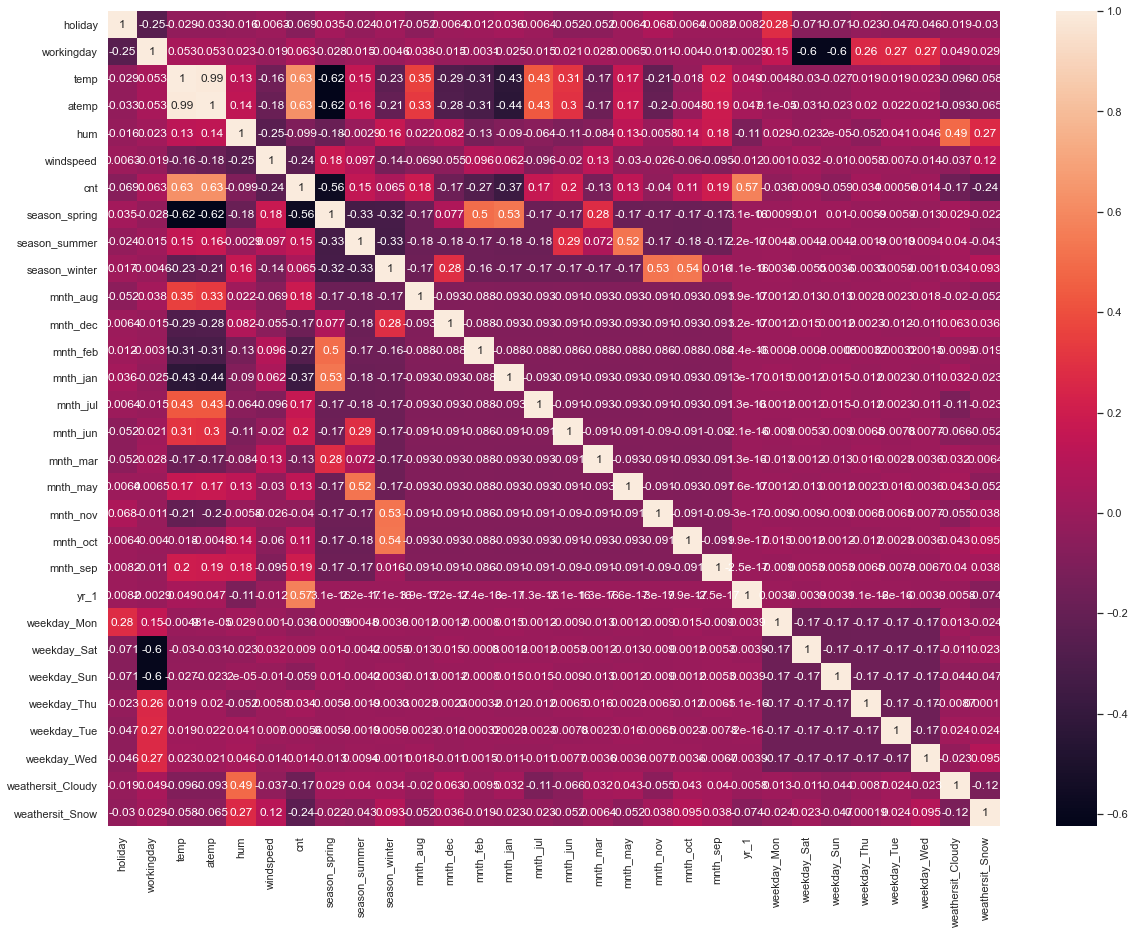

In [295]:
corrMatrix = df.corr()
plt.figure(figsize = (20, 15))
sns.heatmap(corrMatrix, annot=True)
#sns.set(rc={"figure.figsize":(100, 50)}) #width=20, #height=20
plt.show()

### Observation: Clearly from co-relation matrix temp and atemp are directly corelated so we can safely drop one of them as well as spring, summer, winter is directly coreleated to temp/atemp as corelation score  is  > 0.5

temp and CNt are highly corelated

You can see a corelation between month and seasons like May is to Summer and Spring is to Feb and Jan

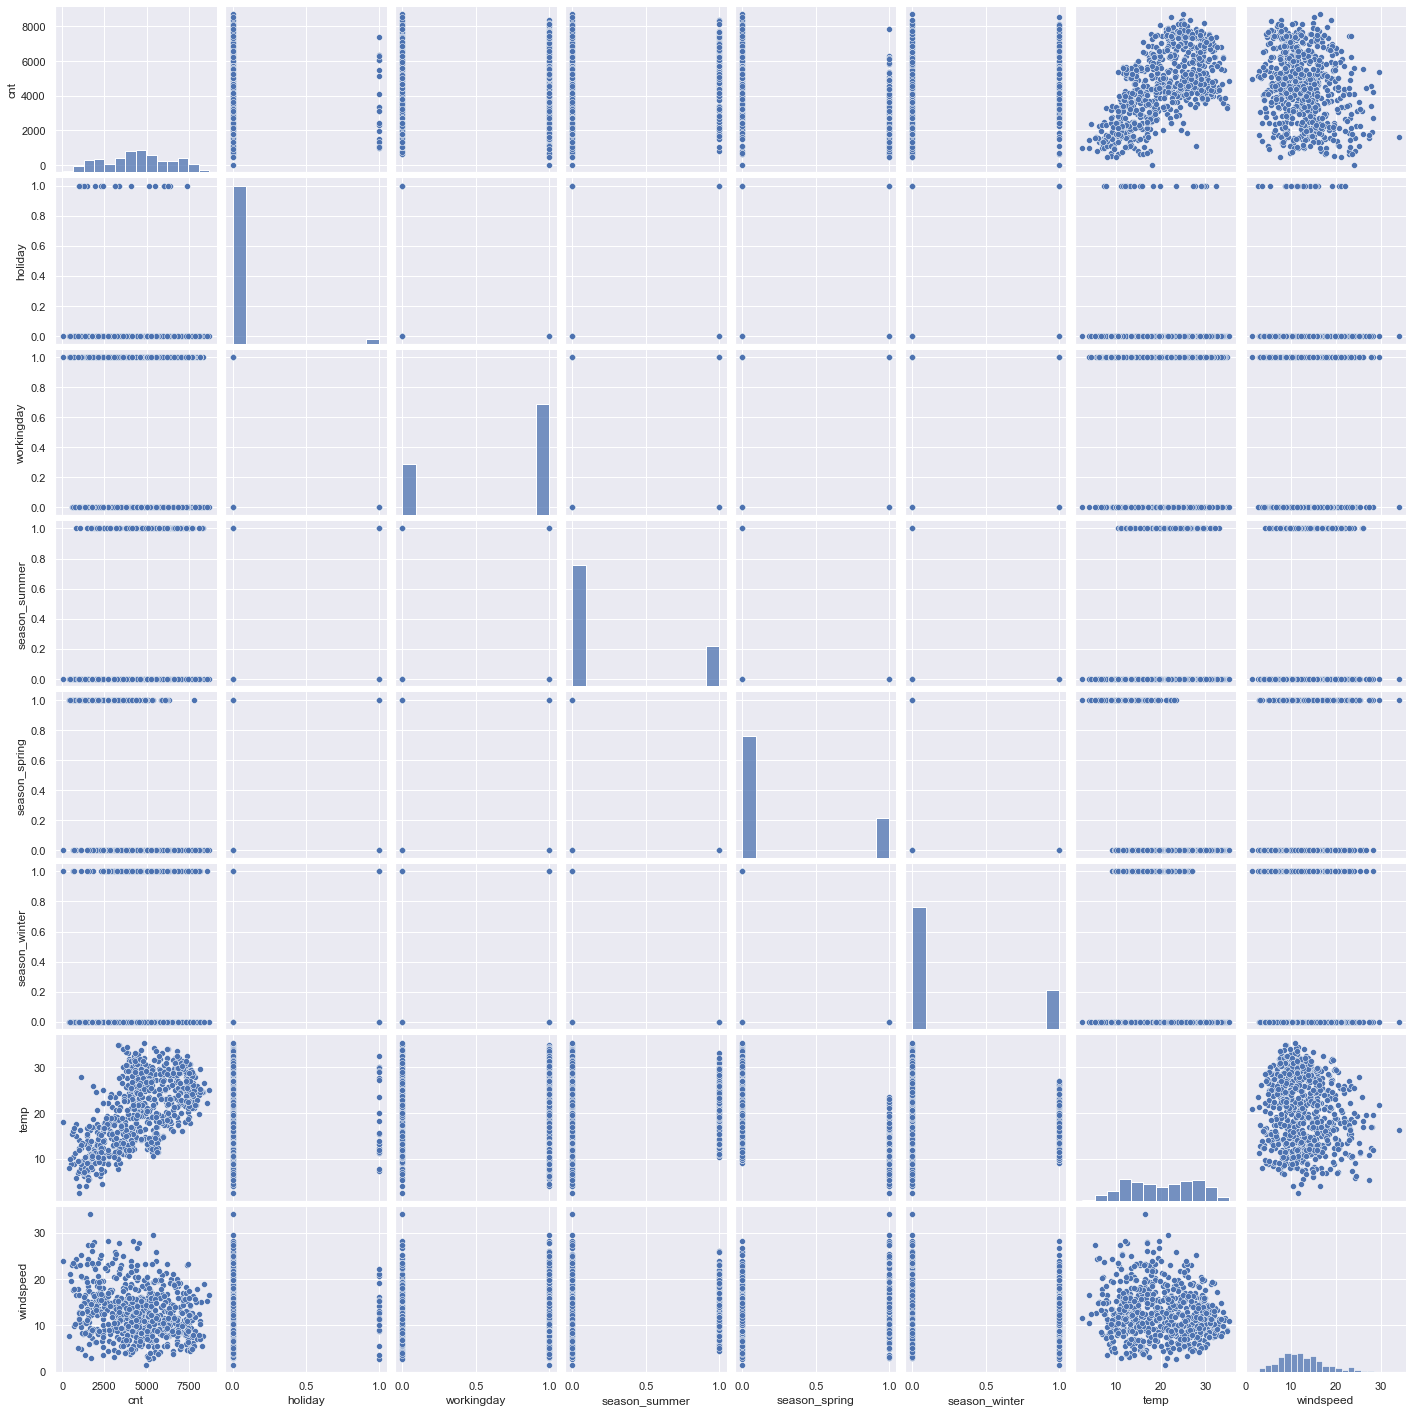

In [296]:
# Create pairplot of all the variables that are correlated from above matrix, lets' remove non colrelated variables to cnt using model
#sns.pairplot(df)  
sns.pairplot(df,vars=['cnt','holiday','workingday','season_summer','season_spring','season_winter','temp','windspeed'])  
plt.show()

### Clear linear coreleation is visible between cnt and temp

### Building our model
This time, we will be using the LinearRegression function from SciKit Learn for its compatibility with RFE (which is a utility from sklearn)

RFE
Recursive feature elimination

In [297]:
###### Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(Xtrain, ytrain)

rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(Xtrain, ytrain)

In [298]:
list(zip(Xtrain.columns,rfe.support_,rfe.ranking_))

[('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 10),
 ('season_winter', True, 1),
 ('mnth_aug', False, 12),
 ('mnth_dec', True, 1),
 ('mnth_feb', False, 3),
 ('mnth_jan', False, 2),
 ('mnth_jul', True, 1),
 ('mnth_jun', False, 9),
 ('mnth_mar', False, 11),
 ('mnth_may', False, 7),
 ('mnth_nov', True, 1),
 ('mnth_oct', False, 6),
 ('mnth_sep', False, 5),
 ('yr_1', True, 1),
 ('weekday_Mon', False, 8),
 ('weekday_Sat', True, 1),
 ('weekday_Sun', True, 1),
 ('weekday_Thu', False, 15),
 ('weekday_Tue', False, 13),
 ('weekday_Wed', False, 14),
 ('weathersit_Cloudy', False, 4),
 ('weathersit_Snow', True, 1)]

In [299]:
col = Xtrain.columns[rfe.support_]
col

Index(['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'season_spring', 'season_winter', 'mnth_dec', 'mnth_jul', 'mnth_nov',
       'yr_1', 'weekday_Sat', 'weekday_Sun', 'weathersit_Snow'],
      dtype='object')

## Building model using statsmodel, for the detailed statistics

In [300]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = Xtrain[col]

In [301]:

def calulateVIF(X_train_new):
    vif = pd.DataFrame()
    X = X_train_new
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def getStatModel(X_train_rfe,ytrain):
    X_train_rfe = sm.add_constant(X_train_rfe)
    lm = sm.OLS(ytrain,X_train_rfe).fit()   # Running the linear model
    return lm

def getStatModelSummary(X_train_rfe,ytrain):
    lm = getStatModel(X_train_rfe,ytrain)
    return lm.summary()

In [302]:
print(getStatModelSummary(X_train_rfe,ytrain))
print(calulateVIF(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     190.2
Date:                Mon, 04 Apr 2022   Prob (F-statistic):          4.96e-189
Time:                        15:52:42   Log-Likelihood:                 485.71
No. Observations:                 511   AIC:                            -941.4
Df Residuals:                     496   BIC:                            -877.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2885      0.026     

In [303]:
#lets drop column Holiday since it has very high P value i.e. > 0.05 significance level
X_train_rfe = X_train_rfe.drop(["holiday"], axis = 1)
print(getStatModelSummary(X_train_rfe,ytrain))
print(calulateVIF(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     190.2
Date:                Mon, 04 Apr 2022   Prob (F-statistic):          4.96e-189
Time:                        15:52:42   Log-Likelihood:                 485.71
No. Observations:                 511   AIC:                            -941.4
Df Residuals:                     496   BIC:                            -877.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3037      0.041     

In [304]:
#lets drop column atemp       since it has very high P value i.e. > 0.05 significance level, anyways from correlation matrix we found temp and atemp were correlated
X_train_rfe = X_train_rfe.drop(["atemp"], axis = 1)
print(getStatModelSummary(X_train_rfe,ytrain))
print(calulateVIF(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     204.3
Date:                Mon, 04 Apr 2022   Prob (F-statistic):          8.70e-190
Time:                        15:52:42   Log-Likelihood:                 484.74
No. Observations:                 511   AIC:                            -941.5
Df Residuals:                     497   BIC:                            -882.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3097      0.041     

In [305]:
#lets drop column mnth since it has very high P value i.e. > 0.05 significance level
X_train_rfe = X_train_rfe.drop(["weekday_Sun"], axis = 1)
print(getStatModelSummary(X_train_rfe,ytrain))
print(calulateVIF(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     220.3
Date:                Mon, 04 Apr 2022   Prob (F-statistic):          2.26e-190
Time:                        15:52:42   Log-Likelihood:                 483.32
No. Observations:                 511   AIC:                            -940.6
Df Residuals:                     498   BIC:                            -885.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3503      0.033     

### Observation: There are no p value greater than 0.05 but there are still some columns where VIF is > 5 let's drop those to simplify our model

In [306]:
#lets drop column hum since it has very VIF i.e. > 5
X_train_rfe = X_train_rfe.drop(["hum"], axis = 1)
print(getStatModelSummary(X_train_rfe,ytrain))
print(calulateVIF(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     208.2
Date:                Mon, 04 Apr 2022   Prob (F-statistic):          1.68e-178
Time:                        15:52:43   Log-Likelihood:                 452.39
No. Observations:                 511   AIC:                            -880.8
Df Residuals:                     499   BIC:                            -829.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1843      0.027     

### Observation Adjusted R-square is decreasing which is not good but we can still drop VIF > 5 to simplify the model further but we have already seen temp if correlated to Cnt hence let's not drop it.

In [307]:
X_train_rfe.columns

Index(['workingday', 'temp', 'windspeed', 'season_spring', 'season_winter',
       'mnth_dec', 'mnth_jul', 'mnth_nov', 'yr_1', 'weekday_Sat',
       'weathersit_Snow'],
      dtype='object')

In [308]:
print(getStatModelSummary(X_train_rfe,ytrain))
print(calulateVIF(X_train_rfe))
# X_train_rfe = X_train_rfe.drop(["const"], axis = 1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     208.2
Date:                Mon, 04 Apr 2022   Prob (F-statistic):          1.68e-178
Time:                        15:52:43   Log-Likelihood:                 452.39
No. Observations:                 511   AIC:                            -880.8
Df Residuals:                     499   BIC:                            -829.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1843      0.027     

### Seems model is prepared as probablity is < 0.05 and VIF are not > 5(Exception of temp)

### Residual Analysis of the train data
So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [309]:
getStatModel(X_train_rfe,ytrain).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     208.2
Date:                Mon, 04 Apr 2022   Prob (F-statistic):          1.68e-178
Time:                        15:52:43   Log-Likelihood:                 452.39
No. Observations:                 511   AIC:                            -880.8
Df Residuals:                     499   BIC:                            -829.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1843      0.027      6.913      0.000       0.132       0.237
workingday          0.0405      0.012      3.327      0.001       0.017       0.064
temp                0.4272      0.033     13.120      0.000       0.363       0.491
windspeed          -0.1059      0.023     -4.587      0.000      -0.151      -0.061
season_spring      -0.1318      0.017     -7.848      0.000      -0.165      -0.099
season_winter       0.0733      0.016      4.714      0.000       0.043       0.104
mnth_dec           -0.0679      0.018     -3.679      0.000      -0.104      -0.032
mnth_jul           -0.0587      0.019     -3.161      0.002      -0.095      -0.022
mnth_nov           -0.0691      0.021     -3.336      0.001      -0.110      -0.028
yr_1                0.2575      0.009     28.467      0.000       0.240       0.275
weekday_Sat         0.0643      0.016      4.049      0.000       0.033       0.096
weathersit_Snow    -0.2298      0.031     -7.372      0.000      -0.291      -0.169
==============================================================================
Omnibus:                       56.509   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.810
Skew:                          -0.702   Prob(JB):                     1.57e-21
Kurtosis:                       4.590   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [310]:
X_train_error =X_train_rfe 
X_train_error = sm.add_constant(X_train_error)
lm = sm.OLS(ytrain,X_train_error).fit()   # Running the linear model
print(X_train_error.shape)
ytrain_pred=getStatModel(X_train_error,ytrain).predict(X_train_error)

(511, 12)


Text(0.5, 0, 'Errors')

<Figure size 432x288 with 0 Axes>

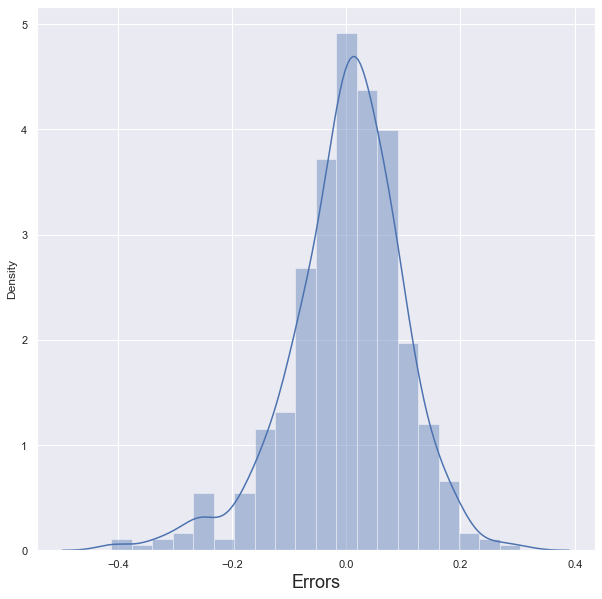

In [311]:
# Plot the histogram of the error terms
fig = plt.figure()
plt.figure(figsize = (10, 10))
sns.distplot((ytrain - ytrain_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Making Predictions
Applying the scaling on the test sets

In [312]:
num_cols = ['temp','atemp','hum','windspeed','cnt']
std = MinMaxScaler()
Xtest[num_cols] = std.fit_transform(Xtest[num_cols])
Xtest


,instant,dteday,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,mnth_sep,yr_1,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Snow
667,668,30-10-2019,0,1,0.328245,0.303008,0.814745,0.392968,87,1009,...,0,1,0,0,0,0,1,0,1,0
541,542,26-06-2019,0,1,0.724405,0.676840,0.236953,0.670521,1077,6365,...,0,1,0,0,0,0,1,0,0,0
429,430,06-03-2019,0,1,0.252410,0.230988,0.343450,0.367953,221,3735,...,0,1,0,0,0,0,1,0,0,0
150,151,31-05-2018,0,1,0.907080,0.848374,0.573482,0.183349,673,3309,...,0,0,0,0,0,0,1,0,0,0
296,297,24-10-2018,0,1,0.512166,0.496173,0.746538,0.198734,699,3488,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,621,13-09-2019,0,1,0.701176,0.656959,0.574014,0.124372,1054,6750,...,1,1,0,0,0,1,0,0,0,0
165,166,15-06-2018,0,1,0.719127,0.667717,0.362620,0.299998,769,4411,...,0,0,0,0,0,0,0,1,0,0
180,181,30-06-2018,0,1,0.807824,0.732369,0.314696,0.335869,1027,4488,...,0,0,0,0,0,1,0,0,0,0
668,669,31-10-2019,0,1,0.378065,0.370203,0.611821,0.297431,419,5147,...,0,1,0,0,0,0,0,1,1,0


In [313]:
ytest = Xtest.pop('cnt')

In [314]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
Xtest_new = Xtest[X_train_rfe.columns]

# Adding a constant variable 
Xtest_new = sm.add_constant(Xtest_new)

In [315]:
# Making predictions
ypred = lm.predict(Xtest_new)

### Model Evaluation

Text(0, 0.5, 'ypred')

<Figure size 432x288 with 0 Axes>

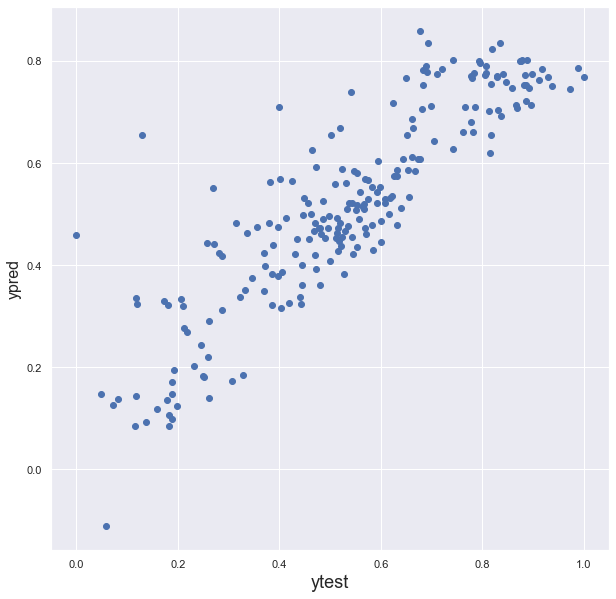

In [316]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.figure(figsize = (10, 10))
plt.scatter(ytest,ypred)
fig.suptitle('ytest vs ypred', fontsize=20)              # Plot heading 
plt.xlabel('ytest', fontsize=18)                          # X-label
plt.ylabel('ypred', fontsize=16)                          # Y-label

In [317]:
### Observation:ytest vs ypred plot is quite linear

In [318]:
from sklearn.metrics import r2_score
print('Train R-Score: ' ,r2_score(ytrain,ytrain_pred))  # R score for train data
print('Test R-Score: ' ,r2_score(ytest, ypred))

r2_score(ytest, ypred)

Train R-Score:  0.8211105410351409
Test R-Score:  0.7637356957382501


0.7637356957382501

In [319]:
X_train_rfe.columns

Index(['workingday', 'temp', 'windspeed', 'season_spring', 'season_winter',
       'mnth_dec', 'mnth_jul', 'mnth_nov', 'yr_1', 'weekday_Sat',
       'weathersit_Snow'],
      dtype='object')

### Observations: 
Significant variables to predict the demand for shared bikes are 'workingday', 'temp', 'windspeed', 'season_spring--season', 'season_winter--season',
       'mnth_dec---month', 'mnth_jul --month', 'mnth_nov --month', 'yr_1---year(2019)', 'weekday_Sat --weekday',
       'weathersit_Snow--weathersit'